# Projeto de Regressão Linear Bayesiana

Implementaremos um modelo a partir da BAyesian Model-Building Interface (Bambi) em python.

## Bambi

Mas o que é a Bambi? 

Bambi é uma interface de construção de modelo Bayesiano. Trabalhando junto com os frameworks de programação probabilísticos PyMC, projetado para facilitar o ajuste dos modelos mistos Bayesianos comuns em biologia, ciência sociais dentre outras disciplinas.

## Dataset

Utilizaremos dados extraídos do artigo "CowNflow: A dataset on nitrogen flows and balances in dairy cows fed maize forage or herbage-based diets", do site https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8479390/, qual trata a dieta e as características dos animais têm um impacto significativo na eficiência do uso de nitrogênio (N) de vacas leiteiras.

In [ ]:
!pip install bambi pymc

In [2]:
import pymc as pm
import bambi as bmb
import pandas as pd
import arviz as az

In [3]:
df = pd.read_excel('/content/CowNflow_6_Cow_measurements_edited.xlsx')

In [4]:
df.drop(df[df.Physiological_status == 'dry'].index, inplace=True)

In [5]:
df = df.drop(columns=['Physiological_status'])

In [6]:
df.fillna(0,inplace=True)

In [7]:
df = df.sort_values('Cow_age__month')

In [8]:
df.reset_index(drop=True)

,Cow_number,Cow_age__month,Body_weight__kg,Lactation_week,Gestation_status,Gestation_week,Diet_type,"Forage_proportion_in_the_diet__kg_kg,_DM_basis","Maize_forage_proportion_in_the_diet__kg_kg,_DM_basis","Fresh_herbage_proportion_in_the_diet__kg_kg,_DM_basis",...,Urinary_N_concentration__g_kg,Urinary_urea_concentration__g_kg,Urinary_N_excretion__g_day,Urinary_urea_excretion__g_day,Basal_plasma_urea_concentration__mg_dL,Plasma_urea_concentration_3h_after_feeding__mg_dL,Plasma_urea_concentration4h_after_feeding__mg_dL,Plasma_urea_concentration_6h_after_feeding__mg_dL,N_balance__g_day,N_use_efficiency__milk_N_excretion___N_intake
0,6210,31,638,17,pregnant,7,Maize,0.743,0.743,0.000,...,8.1,9.8,101.0,125.0,0.0,0.0,0.0,0.0,32.4,0.353
1,6193,31,682,12,not pregnant,0,Maize,0.743,0.743,0.000,...,7.7,9.9,102.0,133.0,0.0,0.0,0.0,0.0,66.1,0.352
2,81130,32,496,38,pregnant,28,Fresh_herbage,1.000,0.000,1.000,...,7.1,0.0,185.0,0.0,0.0,0.0,0.0,0.0,41.4,0.144
3,6193,32,644,15,not pregnant,0,Maize,0.743,0.743,0.000,...,7.3,9.9,105.0,143.0,0.0,0.0,0.0,0.0,58.3,0.353
4,81138,32,485,36,not pregnant,0,Fresh_herbage,1.000,0.000,1.000,...,5.4,0.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,82063,131,605,26,not pregnant,0,Fresh_herbage,0.855,0.000,0.855,...,8.0,13.7,339.0,579.0,49.0,48.7,48.8,48.6,93.5,0.167
399,82226,132,632,30,not pregnant,0,Fresh_herbage,1.000,0.000,1.000,...,6.4,10.0,174.0,272.0,0.0,0.0,0.0,0.0,64.2,0.244
400,82226,132,634,28,not pregnant,0,Fresh_herbage,0.836,0.000,0.836,...,8.0,11.4,258.0,365.0,39.8,39.8,38.3,37.9,51.8,0.224
401,82063,132,625,27,not pregnant,0,Fresh_herbage,1.000,0.000,1.000,...,7.5,12.7,339.0,577.0,43.3,42.8,44.1,44.9,73.1,0.172


## Analisando a produção diária de leite

In [9]:
df['Milk_production__kg_day'].describe()


count    403.000000
mean      23.770968
std        8.227250
min        0.000000
25%       18.150000
50%       24.100000
75%       29.300000
max       47.000000
Name: Milk_production__kg_day, dtype: float64

In [10]:
df['Milk_production__kg_day'].value_counts()

22.1    5
26.4    5
19.9    5
12.1    4
18.7    4
       ..
12.8    1
29.7    1
8.8     1
15.2    1
21.5    1
Name: Milk_production__kg_day, Length: 226, dtype: int64

## Analisando a Dieta em relação a produção diária

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

import seaborn as sns

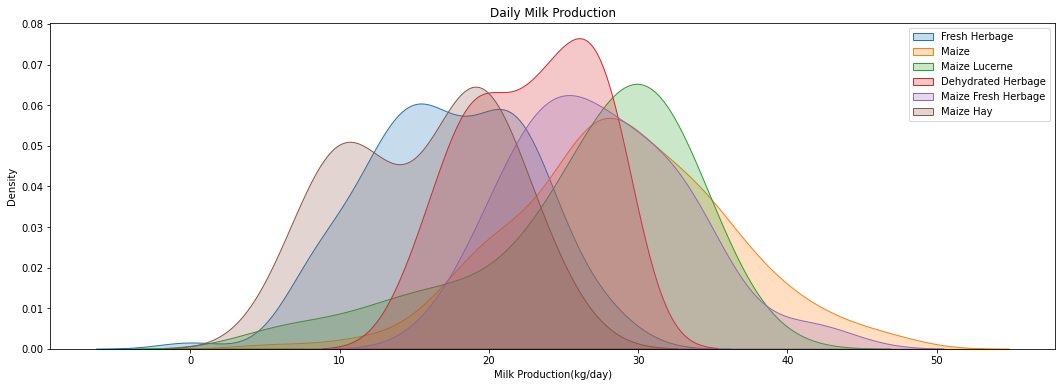

In [12]:
#Produção Diária por Tipo de Dieta
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (18, 6)

sns.kdeplot(df.loc[df['Diet_type'] == 'Fresh_herbage', 'Milk_production__kg_day'], label = 'Fresh Herbage', fill=True)
sns.kdeplot(df.loc[df['Diet_type'] == 'Maize', 'Milk_production__kg_day'], label = 'Maize', fill=True)
sns.kdeplot(df.loc[df['Diet_type'] == 'Maize_Lucerne', 'Milk_production__kg_day'], label = 'Maize Lucerne', fill=True)
sns.kdeplot(df.loc[df['Diet_type'] == 'Dehydrated_herbage', 'Milk_production__kg_day'], label = 'Dehydrated Herbage', fill=True)
sns.kdeplot(df.loc[df['Diet_type'] == 'Maize_Fresh_herbage', 'Milk_production__kg_day'], label = 'Maize Fresh Herbage', fill=True)
sns.kdeplot(df.loc[df['Diet_type'] == 'Maize_Hay', 'Milk_production__kg_day'], label = 'Maize Hay', fill=True)
plt.xlabel('Milk Production(kg/day)'); plt.ylabel('Density'); plt.title('Daily Milk Production');
plt.legend();

## Criando o modelo Bambi

Modelo criado a partir do tipo da dieta, a concentração de N, a idade e a semana de lactação.

In [18]:
model = bmb.Model("Milk_production__kg_day ~ Diet_type + N_use_efficiency__milk_N_excretion___N_intake + Cow_age__month + Lactation_week + (Cow_age__month|Cow_number)", df)
fitted = model.fit(tune=3000)

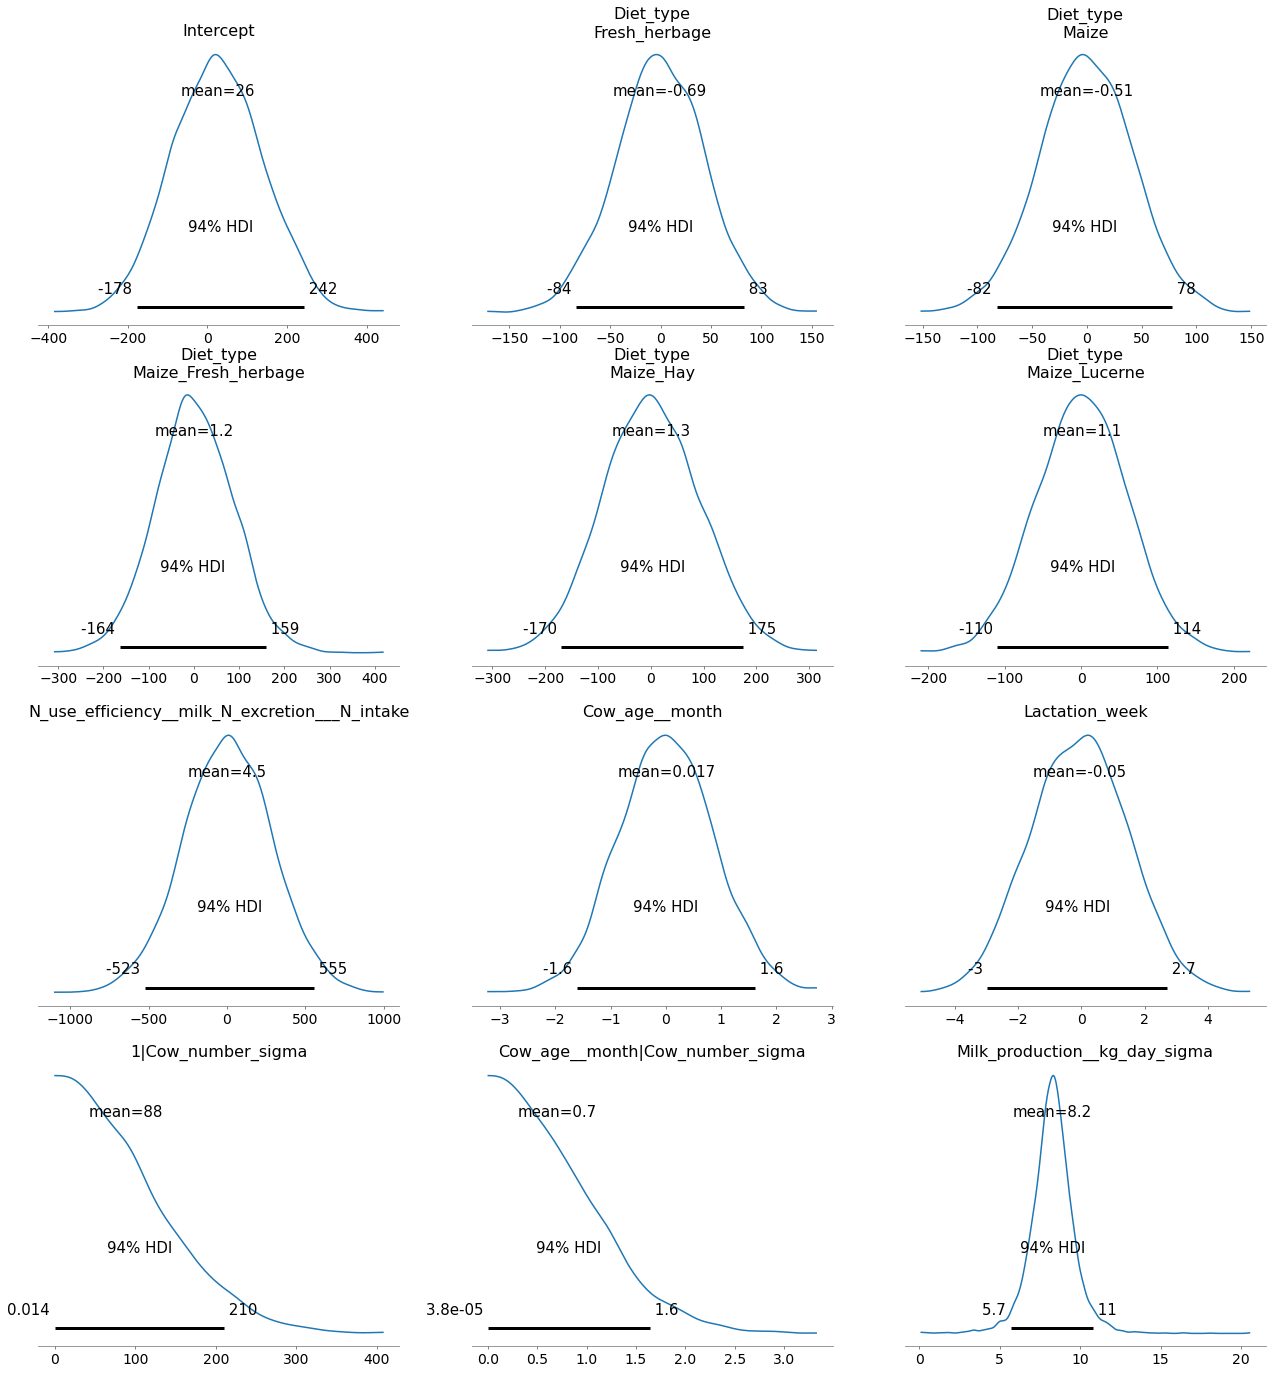

In [32]:
model.plot_priors(figsize=(22,len(fitted)*6));

Analisando o modelo criado

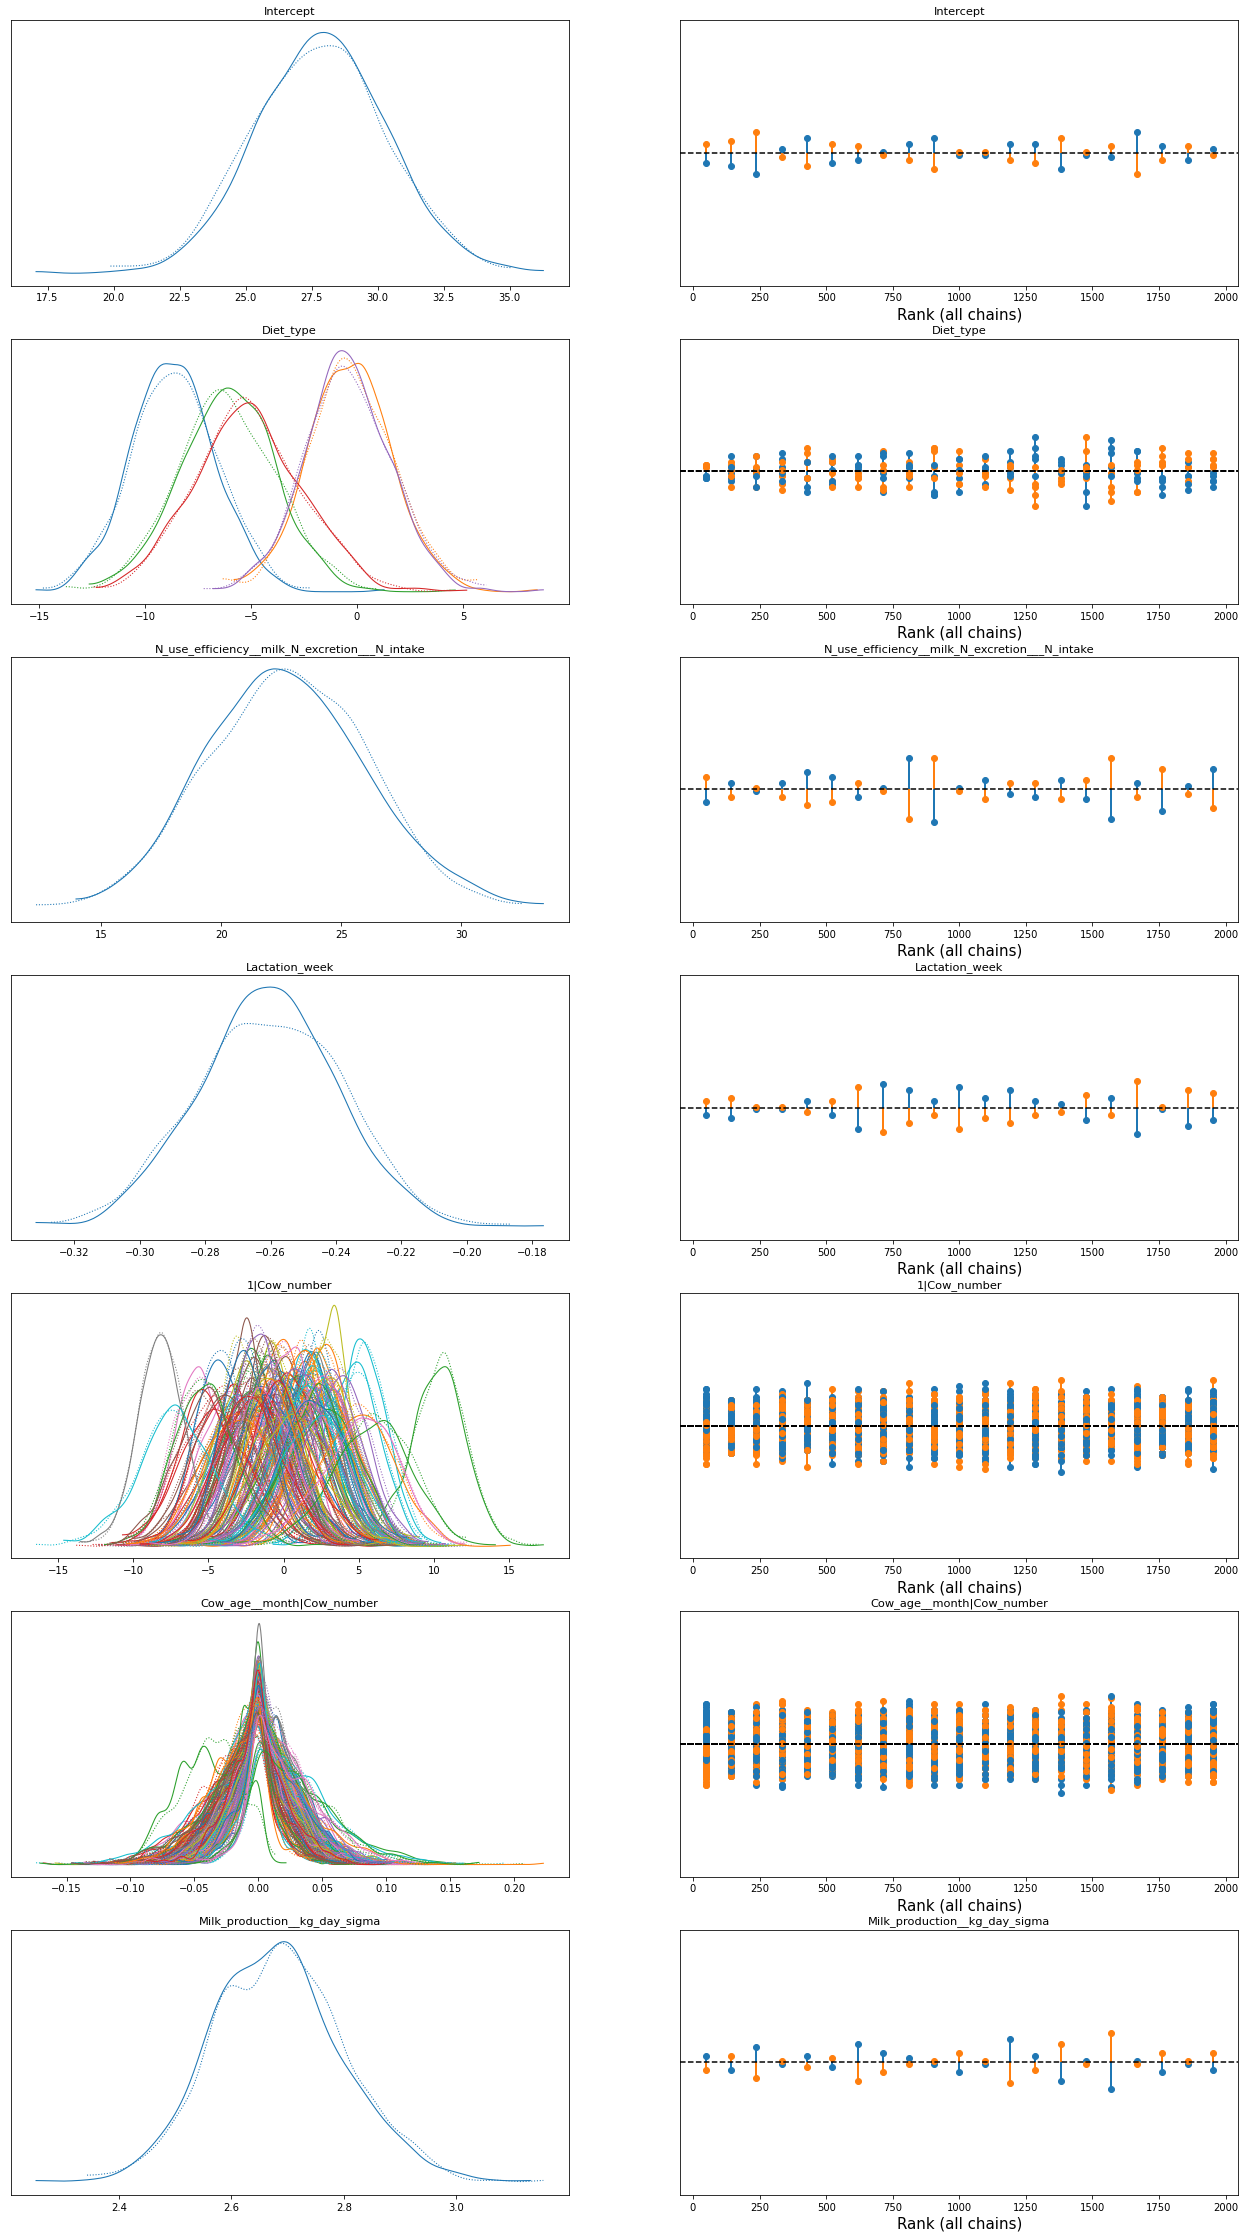

In [29]:
az.plot_trace(fitted, var_names=["Intercept", "Diet_type", "N_use_efficiency__milk_N_excretion___N_intake", "Lactation_week", "1|Cow_number", "Cow_age__month|Cow_number" , "Milk_production__kg_day_sigma"], kind="rank_vlines", compact=True, figsize=(22,len(fitted)*10));

In [20]:
az.summary(fitted, var_names=["Intercept", "Lactation_week","1|Cow_number_sigma", "Cow_age__month|Cow_number_sigma" , "Milk_production__kg_day_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,27.839,2.500,23.412,32.699,0.084,0.059,888.0,1042.0,1.00
Lactation_week,-0.261,0.022,-0.301,-0.219,0.001,0.000,1455.0,1347.0,1.00
1|Cow_number_sigma,3.561,0.406,2.800,4.314,0.017,0.012,555.0,1012.0,1.00
Cow_age__month|Cow_number_sigma,0.026,0.011,0.000,0.043,0.001,0.001,89.0,156.0,1.03
Milk_production__kg_day_sigma,2.683,0.118,2.481,2.923,0.005,0.003,637.0,1120.0,1.00


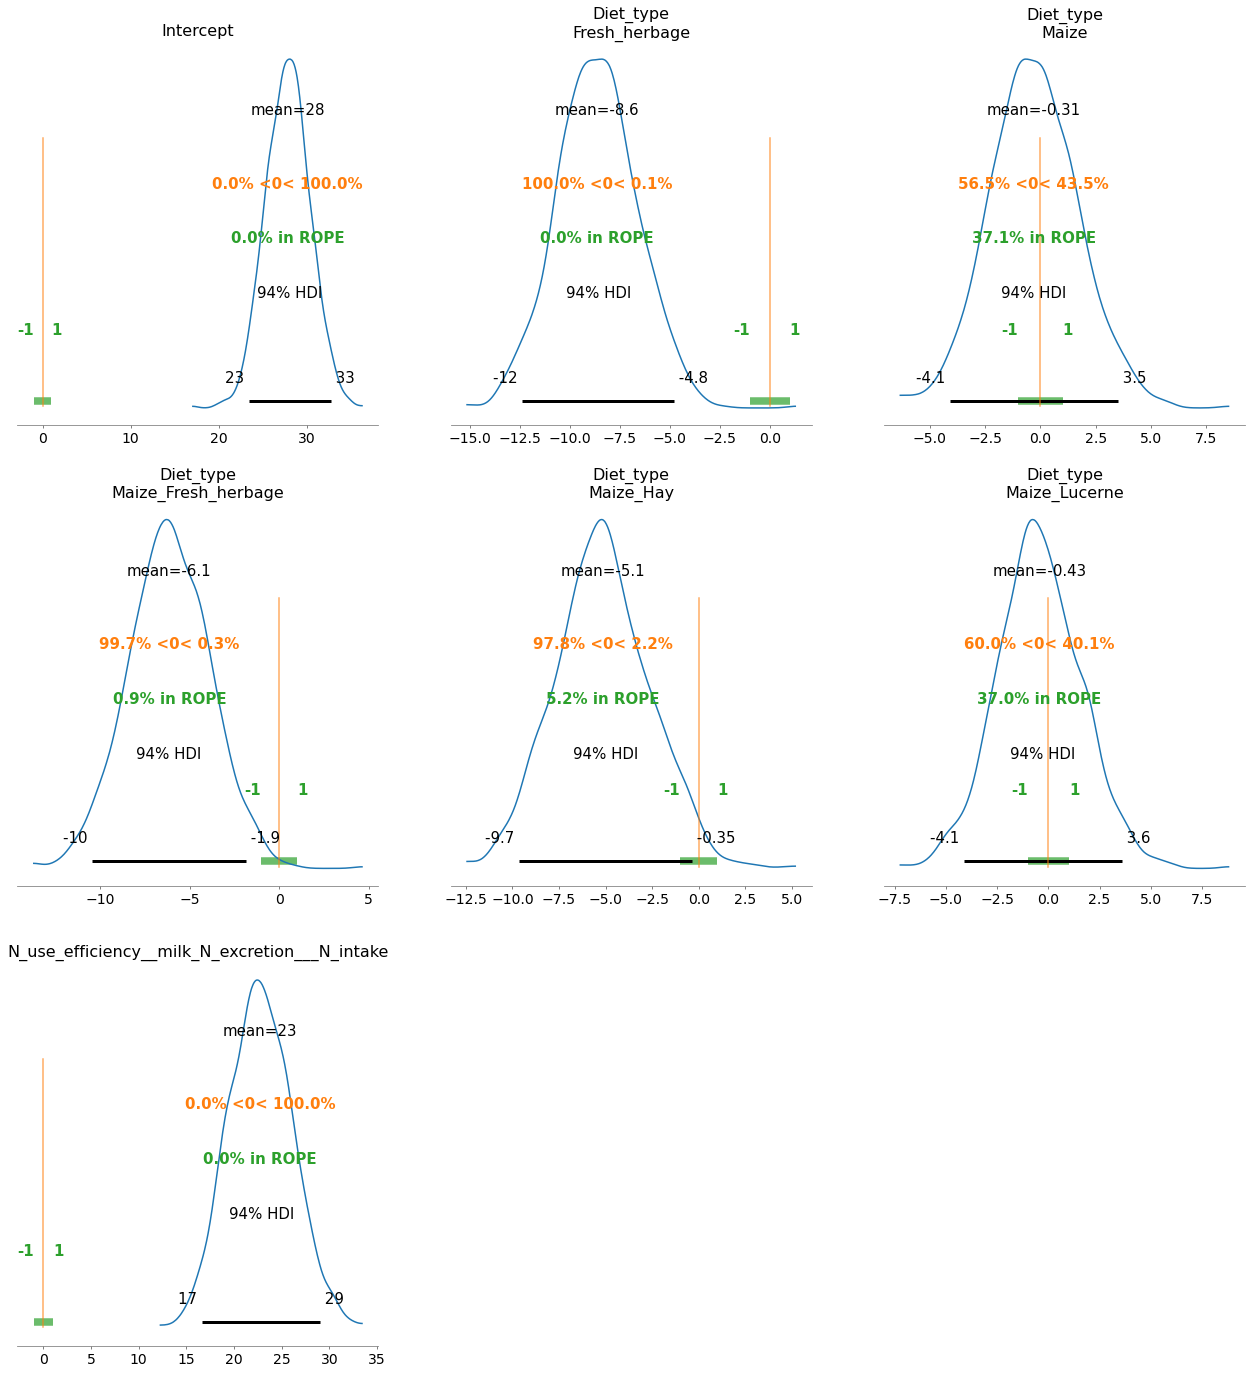

In [33]:
az.plot_posterior(fitted, var_names=["Intercept", "Diet_type", "N_use_efficiency__milk_N_excretion___N_intake"], ref_val=0, rope=[-1, 1],figsize=(22,len(fitted)*6));

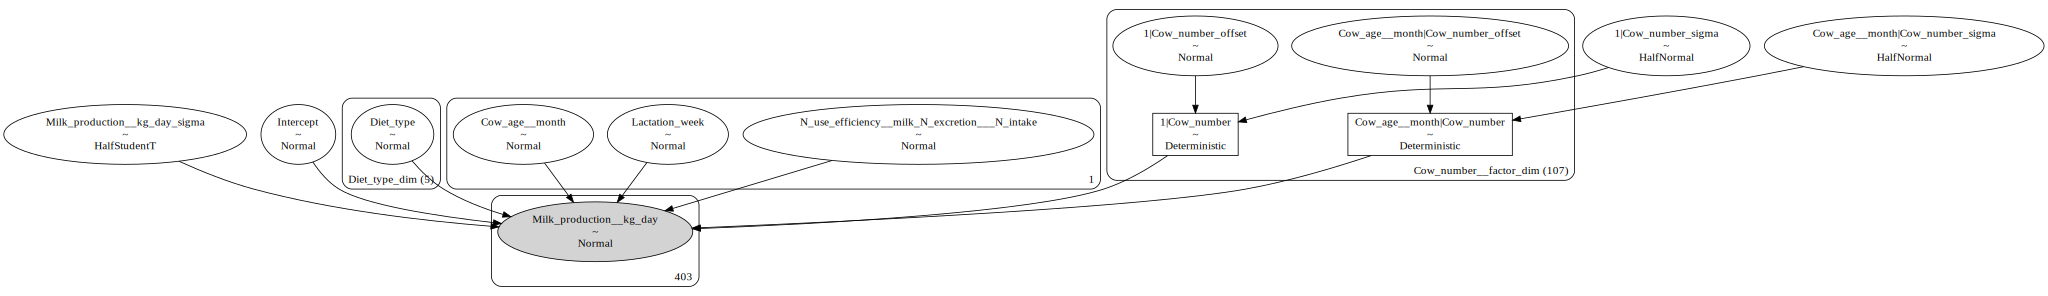

In [36]:
model.graph()

In [23]:
import numpy as np
import xarray as xr

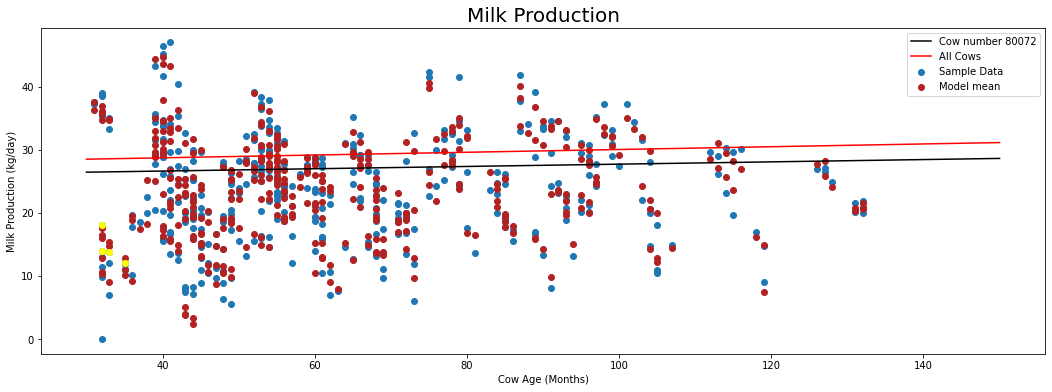

In [24]:
model.predict(fitted, data=df)

posterior_stacked =  az.extract_dataset(fitted)

y_hat = posterior_stacked["Milk_production__kg_day_mean"]
y_hat_mean = y_hat.mean('sample')

hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)


time = np.array([30, 150])

time_xi = xr.DataArray(time)

cow_80072 = df[df['Cow_number']== 80072][['Cow_age__month','Milk_production__kg_day']]

intercept_common = posterior_stacked["Intercept"]
slope_common = posterior_stacked["Cow_age__month"]

intercept_specific_80072 = posterior_stacked["1|Cow_number"].sel(Cow_number__factor_dim="80072")
slope_specific_80072 = posterior_stacked["Cow_age__month|Cow_number"].sel(Cow_number__factor_dim="80072")

a_80072 = (intercept_common + intercept_specific_80072)
b_80072 = (slope_common + slope_specific_80072)



_, ax = plt.subplots()
ax.scatter(df["Cow_age__month"],df["Milk_production__kg_day"], label='Sample Data');


ax.scatter(df["Cow_age__month"], y_hat_mean, c="firebrick", label='Model mean')
#ax.fill_between(df["Cow_age__month"], hdi_data[0], hdi_data[1], alpha=0.4, c="firebrick")

plt.scatter(cow_80072['Cow_age__month'], cow_80072['Milk_production__kg_day'], c='yellow');
plt.plot(time_xi, a_80072.mean() + b_80072.mean() * time_xi, c="black", label='Cow number 80072')

plt.plot(time_xi, intercept_common.mean() + slope_common.mean() * time_xi, c="red", label='All Cows')


ax.set_title("Milk Production", fontsize=20)
plt.ylabel("Milk Production (kg/day)")
plt.xlabel("Cow Age (Months)")
plt.legend(loc=0);


In [ ]:
!pip install watermark

In [26]:
%load_ext watermark

%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Fri Sep 30 2022

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

aesara: 2.7.9
aeppl : 0.0.33

xarray    : 0.20.2
arviz     : 0.12.1
matplotlib: 3.2.2
bambi     : 0.9.1
numpy     : 1.21.6
seaborn   : 0.11.2
pandas    : 1.3.5
pymc      : 4.1.4

Watermark: 2.3.1



## Conclusão

Esse foi um exemplo simples de criação de modelo pelo Bambi. 

Mas podemos observar quantas possibilidades a mais poderiamos ter.

Esse exemplo, confecionado por mim, é somente de interesse didático.